In [39]:
import random
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('artifact_database.csv')

In [3]:
def set_sim(num_sample, the_condition):
    
    df_sample = df.sample(num_sample)
    
    # the max er for each position with target main

    df1 = df_sample[ (df_sample["position"] == "flower") ].sort_values(by=the_condition["sub"], ascending=False).head(n=1)
    df2 = df_sample[ (df_sample["position"] == "plume") ].sort_values(by=the_condition["sub"], ascending=False).head(n=1)
    df3 = df_sample[ (df_sample["position"] == "sands") & (df_sample["main"] == the_condition["main"][0]) ].sort_values(
        by=["er"], ascending=False).head(n=1)
    df4 = df_sample[ (df_sample["position"] == "goblet") & (df_sample["main"] == the_condition["main"][1]) ].sort_values(
        by=["er"], ascending=False).head(n=1)
    df5 = df_sample[ (df_sample["position"] == "circlet") & (df_sample["main"] == the_condition["main"][2]) ].sort_values(
        by=["er"], ascending=False).head(n=1)
    
    df_set = pd.concat([df1, df2, df3, df4, df5])
    
    return df_set

In [4]:
the_condition = {
    "main": ["em", "em", "em"],
    "sub": ['er', "em"],
    "threshold": [80]
}

the_default = {
    'number': 0,
    'target': the_condition["sub"][0], 'threshold': the_condition["threshold"][0],
    'prob': 0, 'mean_er': 0, 'stddev_er': 0, 'mean_em': 0, 'stddev_em': 0,
}
the_summary = [the_default]


num_sim = 1000

for i in tqdm(range(1,101)):
    
    the_results = {}
    for the_sub in the_condition["sub"]:
        the_results[the_sub] = []
    
    num_artifact = 10 * i
    
    for _ in range(num_sim):
        
        df_set = set_sim(num_artifact, the_condition)
        
        for the_sub in the_condition["sub"]:
            the_results[the_sub].append(df_set[the_sub].sum())
        
    tmp = the_default.copy()
    tmp["number"] = num_artifact
        
    the_prob = sum(
        the_value > the_condition["threshold"][0] 
        for the_value in the_results[the_condition["sub"][0]]) / num_sim    
    tmp["prob"] = the_prob
    
    for the_sub in the_condition["sub"]:
    
        the_list = the_results[the_sub]
        the_mean = sum(the_list) / len(the_list)
        the_variance = sum([x ** 2 for x in the_list]) / len(the_list) - the_mean ** 2
        the_stddev = the_variance ** 0.5
        
        tmp["mean_%s" % the_sub] = the_mean
        tmp["stddev_%s" % the_sub] = the_stddev
    
    the_summary.append(tmp)

100%|██████████| 100/100 [41:38<00:00, 24.99s/it]


In [5]:
df_summary = pd.DataFrame(the_summary)
df_summary = df_summary.fillna(0)
df_summary

,number,target,threshold,prob,mean_er,stddev_er,mean_em,stddev_em
0,0,er,80,0.000,0.000000,0.000000,0.000000,0.000000
1,10,er,80,0.000,16.638696,11.637919,34.463835,34.559445
2,20,er,80,0.000,27.096768,11.708880,35.834463,34.607765
3,30,er,80,0.000,33.053184,11.912523,36.596700,36.105828
4,40,er,80,0.000,36.977472,11.034964,30.482487,31.590604
...,...,...,...,...,...,...,...,...
96,960,er,80,0.958,99.364320,10.651362,26.785521,26.500294
97,970,er,80,0.962,99.085680,10.583249,26.675964,25.369041
98,980,er,80,0.968,99.757656,10.663887,26.645661,25.519419
99,990,er,80,0.963,99.539280,10.549112,27.107199,25.632878


In [6]:
df_summary.to_csv('thoma_set_sim_1000_artifacts_er_only.csv', index=False)

# create 3 figure

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d

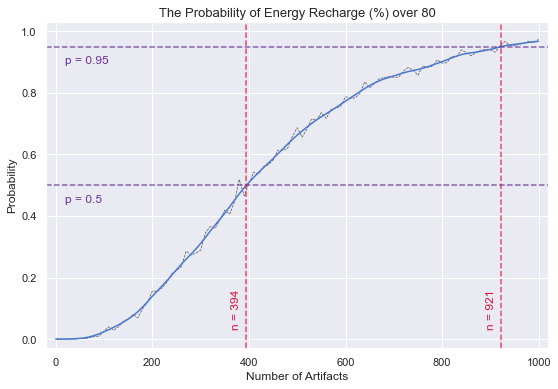

In [174]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(9,6))

x_values = df_summary["number"]
y_values = df_summary["prob"]

# Smoothing
y_values_smooth_part1 = gaussian_filter1d(y_values[:4], sigma=0.1)
y_values_smooth_part2 = gaussian_filter1d(y_values[1:], sigma=2)
y_values_smooth = np.concatenate([y_values_smooth_part1[:3], y_values_smooth_part2[2:]])

ax.plot(x_values, y_values, '--', linewidth=0.7, color='k', alpha=0.75)
ax.plot(x_values, y_values_smooth)

# set x/y range
the_ymax = 1
the_xmax = 1000
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)

# red line p = 0.5
ax.axhline(0.5, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(0.02*the_xmax, 0.5-the_ymax*0.03,'p = 0.5', 
         horizontalalignment='left', verticalalignment='top', color='rebeccapurple',rotation=0)

the_keypoint0 = 394
# red line the number when p = 0.5
ax.axvline(the_keypoint0, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint0-the_xmax*0.01, 0.03*the_ymax, 'n = %d' % the_keypoint0, 
         horizontalalignment='right', verticalalignment='bottom', color='crimson',rotation=90)

# red line p = 0.95
ax.axhline(0.95, ls='--', color='rebeccapurple', alpha=0.75)
plt.text(0.02*the_xmax, 0.95-the_ymax*0.03,'p = 0.95', 
         horizontalalignment='left', verticalalignment='top', color='rebeccapurple',rotation=0)

the_keypoint1 = 921
# red line the number when p = 0.5
ax.axvline(the_keypoint1, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint1-the_xmax*0.01, 0.03*the_ymax, 'n = %d' % the_keypoint1, 
         horizontalalignment='right', verticalalignment='bottom', color='crimson',rotation=90)


ax.set(ylabel='Probability')
ax.set(xlabel='Number of Artifacts')
ax.set_title("The Probability of Energy Recharge (%) over 80", fontsize = 13)

plt.show()

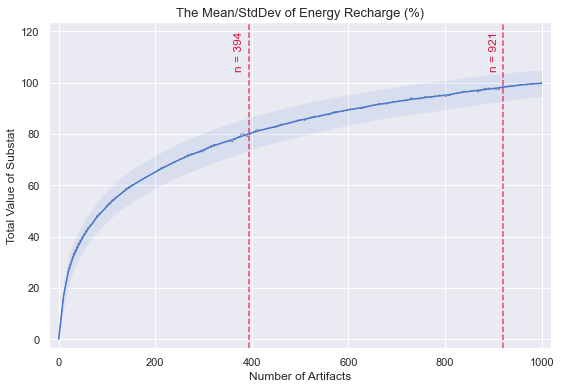

In [168]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(9,6))

x_values = df_summary["number"]
y_values = df_summary["mean_er"]
err_values = df_summary["stddev_er"]

# Smoothing
the_bound = 10
y_values_smooth_part1 = gaussian_filter1d(y_values[:the_bound], sigma=0.1)
y_values_smooth_part2 = gaussian_filter1d(y_values, sigma=2)
y_values_smooth = np.concatenate([
    [ (1-i/the_bound) * y_values_smooth_part1[i]  + (i/the_bound) * y_values_smooth_part2[i]
     for i in range(the_bound)], 
    y_values_smooth_part2[the_bound:]
])

# Error formating
upper_err_part1 = gaussian_filter1d(y_values[:the_bound] + err_values[:the_bound]/2, sigma=0.1)
upper_err_part2 = gaussian_filter1d(y_values + err_values/2, sigma=2)
upper_err = np.concatenate([
    [ (1-i/the_bound) * upper_err_part1[i]  + (i/the_bound) * upper_err_part2[i]
     for i in range(the_bound)], 
    upper_err_part2[the_bound:]
])

lower_err_part1 = gaussian_filter1d(y_values[:the_bound] - err_values[:the_bound]/2, sigma=0.1)
lower_err_part2 = gaussian_filter1d(y_values - err_values/2, sigma=2)
lower_err = np.concatenate([
    [ (1-i/the_bound) * lower_err_part1[i]  + (i/the_bound) * lower_err_part2[i]
     for i in range(the_bound)], 
    lower_err_part2[the_bound:]
])


ax.plot(x_values, y_values, '--', linewidth=0.7, color='k', alpha=0.75)
ax.plot(x_values, y_values_smooth)
ax.fill_between(x_values, upper_err, lower_err, alpha=0.1)

# set x/y range
the_ymax = 120
the_xmax = 1000
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)

# red line of keypoint
ax.axvline(the_keypoint0, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint0-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint0, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)
ax.axvline(the_keypoint1, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint1-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint1, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

ax.set(ylabel='Total Value of Substat')
ax.set(xlabel='Number of Artifacts')

ax.set_title("The Mean/StdDev of Energy Recharge (%)", fontsize = 13)

plt.show()

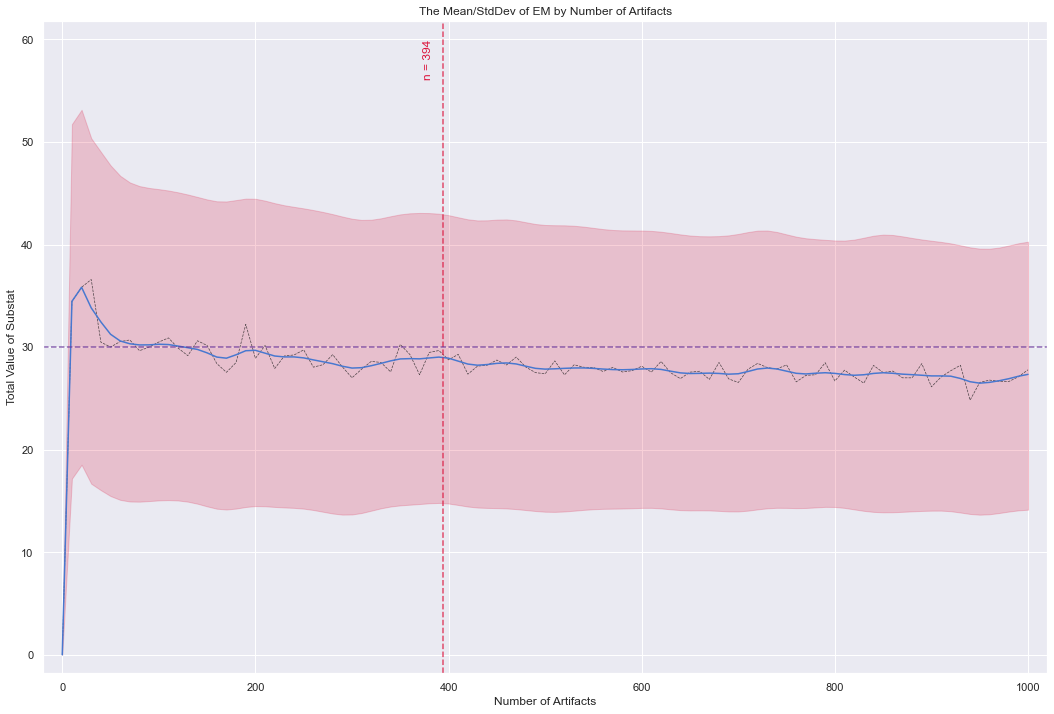

In [80]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(18,12))

x_values = df_summary["number"]
y_values = df_summary["mean_em"]
err_values = df_summary["stddev_em"]

# Smoothing
y_values_smooth_part1 = gaussian_filter1d(y_values[:4], sigma=0.1)
y_values_smooth_part2 = gaussian_filter1d(y_values[1:], sigma=1.5)
y_values_smooth = np.concatenate([y_values_smooth_part1[:3], y_values_smooth_part2[2:]])

# Error formating
upper_err_part1 = gaussian_filter1d(y_values[:4] + (err_values[:4]/2), sigma=0.1)
upper_err_part2 = gaussian_filter1d(y_values[1:] + (err_values[1:]/2), sigma=2)
upper_err = np.concatenate([upper_err_part1[:3], upper_err_part2[2:]])

lower_err_part1 = gaussian_filter1d(y_values[:4] - (err_values[:4]/2), sigma=0.1)
lower_err_part2 = gaussian_filter1d(y_values[1:] - (err_values[1:]/2), sigma=2)
lower_err = np.concatenate([lower_err_part1[:3], lower_err_part2[2:]])

ax.plot(x_values, y_values, '--', linewidth=0.7, color='k', alpha=0.75)
ax.plot(x_values, y_values_smooth)
ax.fill_between(x_values, upper_err, lower_err, color='crimson', alpha=0.2)

# set x/y range
the_ymax = 60
the_xmax = 1000
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)

# red line of keypoint
ax.axvline(the_keypoint0, ls='--', color='crimson', alpha=0.75)
plt.text(the_keypoint0-the_xmax*0.01, the_ymax, 'n = %d' % the_keypoint0, 
         horizontalalignment='right', verticalalignment='top', color='crimson',rotation=90)

the_em = 30
ax.axhline(the_em, ls='--', color='rebeccapurple', alpha=0.75)

ax.set(ylabel='Total Value of Substat')
ax.set(xlabel='Number of Artifacts')

ax.set_title("The Mean/StdDev of EM by Number of Artifacts")

plt.show()